# Plot colony growth rate of Staph-Pseudomonas co-culture

In [1]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#main data analysis packages
import numpy as np
import seaborn as sns
import pandas as pd

#path handling
import pathlib

## Load data

In [31]:
#set path to output csv files
path_data_files = pathlib.Path() 

#set filenames
exp_name = "20230411"

#read data
csv_name = path_data_files / f"{exp_name}_all_data.csv"
df_all = pd.read_csv(csv_name, index_col=0)
df_all.head()

,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,frame,pos,strain,condition,colony_id,col_idx,min_dist_PA_centroid
0,1,818,80.063570,1266.731051,35.040071,31.224062,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,-1,0.0,180.846496
1,2,735,89.469388,1374.753741,43.489829,23.046311,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,-1,1.0,224.546857
2,3,777,102.608752,1551.871300,34.768511,29.621879,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,-1,2.0,105.645573
3,4,235,171.485106,1580.600000,23.340537,13.144388,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,-1,3.0,88.521595
4,5,1282,224.416537,1096.703588,59.640729,28.771840,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,-1,4.0,130.954679


We now remove the PA data, as we only care about SA growth. 

We also removed untracked colonies. 

Then we plot number of colonies as function of time.

In [14]:
df = df_all.loc[(~(df_all['strain']=='PA')) & (df_all['strain']=='PA')]

<AxesSubplot:xlabel='frame', ylabel='size'>

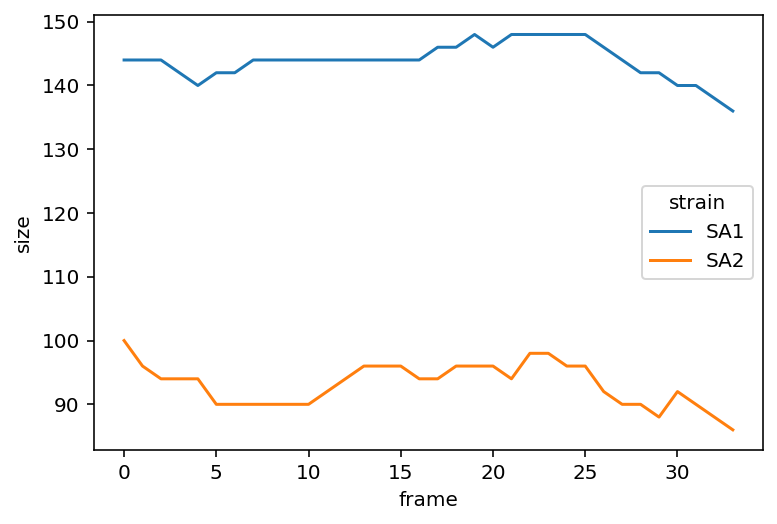

In [30]:
col_num_t = df.groupby(['strain','frame'], as_index=False).size()
sns.lineplot(data=col_num_t, x='frame', y='size', hue='strain')

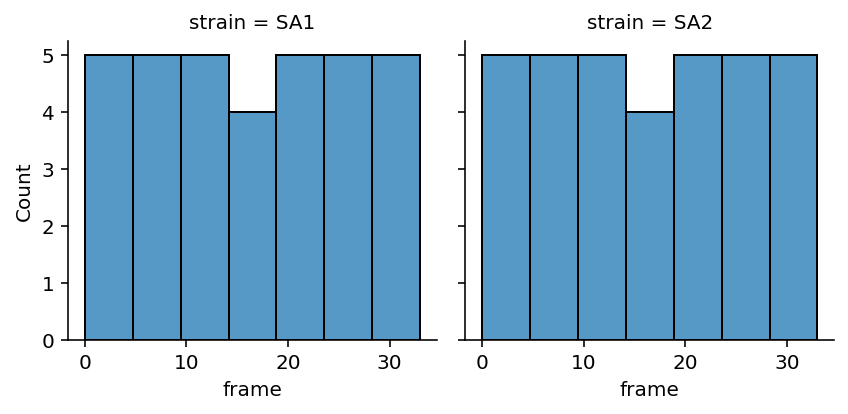

In [29]:
g = sns.FacetGrid(data=col_num_t, col='strain')
g.map_dataframe(sns.histplineplot, x='frame')